In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam



 Define Paths

In [17]:
source_dir = '/kaggle/input/solar-panel-dust-detection/Detect_solar_dust'  # Directory containing 'Clean' and 'Dusty'
train_dir = 'path_to_training_data'  # Directory where training data will be stored
test_dir = 'path_to_test_data'        # Directory where test data will be stored

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define classes
classes = ['Clean', 'Dusty']

for cls in classes:
    class_path = os.path.join(source_dir, cls)
    train_class_path = os.path.join(train_dir, cls)
    test_class_path = os.path.join(test_dir, cls)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    images = os.listdir(class_path)
    
    # Split images into training and testing sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
        
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))


 Data Preprocessing

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing the images
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Your training directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,  # Your validation/test directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2049 images belonging to 2 classes.
Found 513 images belonging to 2 classes.


 Build the CNN Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the model architecture
model = Sequential([
    Input(shape=(150, 150, 3)),  # Input layer to define the shape of input images
    Conv2D(32, (3, 3), activation='relu'),  # First Conv layer with 32 filters
    MaxPooling2D(2, 2),  # MaxPooling to reduce spatial dimensions
    
    Conv2D(64, (3, 3), activation='relu'),  # Second Conv layer with 64 filters
    MaxPooling2D(2, 2),  # MaxPooling
    
    Conv2D(128, (3, 3), activation='relu'),  # Third Conv layer with 128 filters
    MaxPooling2D(2, 2),  # MaxPooling
    
    Flatten(),  # Flatten the output to feed into Dense layers
    
    Dense(128, activation='relu'),  # Fully connected layer with 128 neurons
    Dropout(0.5),  # Dropout to prevent overfitting by randomly turning off 50% of neurons
    
    Dense(1, activation='sigmoid')  # Output layer for binary classification (sigmoid activation)
])

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to see the architecture
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model


In [23]:
# Verify that the data is correctly loaded
for data_batch, labels_batch in train_generator:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break


Data batch shape: (32, 150, 150, 3)
Labels batch shape: (32,)


In [24]:
try:
    # Start training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=50
    )
except Exception as e:
    # Print the error message
    print(f"An error occurred during training: {str(e)}")
    
    # Print the traceback for debugging
    import traceback
    traceback.print_exc()



Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5602 - loss: 0.8520 - val_accuracy: 0.6113 - val_loss: 0.6379
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.7188 - loss: 0.6134 - val_accuracy: 1.0000 - val_loss: 0.4758
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6146 - loss: 0.6423 - val_accuracy: 0.6562 - val_loss: 0.6508
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - accuracy: 0.4375 - loss: 0.6711 - val_accuracy: 0.0000e+00 - val_loss: 0.7108
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6371 - loss: 0.6435 - val_accuracy: 0.5996 - val_loss: 0.6206
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.6250 - loss: 0.5810 - val_accuracy: 1.0000 - val_loss: 0.3048
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6502 - loss: 0.6340 - val_accuracy: 0.6992 - val_loss: 0.5817
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.6875 - loss: 0.5880 - val_accuracy: 1.0000 - val_loss: 0.3513
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6776 - loss: 0.6155 - val_accuracy: 0.6934 - val_loss: 0.5724
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 542us/step - accuracy: 0.6562 - loss: 0.6552 - val_accuracy: 1.0000 - val_los

Evaluate the Model

In [25]:

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")


Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred)


print(confusion_matrix(test_generator.classes, y_pred))
print(classification_report(test_generator.classes, y_pred, target_names=classes))


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 766ms/step - accuracy: 0.7273 - loss: 0.5104
Test accuracy: 0.71
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 784ms/step
[[239  60]
 [172  42]]
              precision    recall  f1-score   support

       Clean       0.58      0.80      0.67       299
       Dusty       0.41      0.20      0.27       214

    accuracy                           0.55       513
   macro avg       0.50      0.50      0.47       513
weighted avg       0.51      0.55      0.50       513



 Visualize Training Results

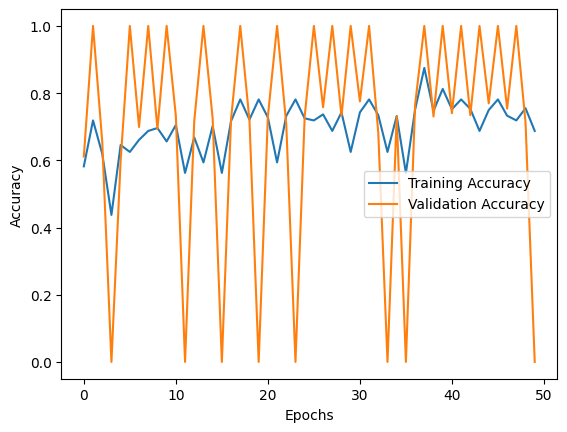

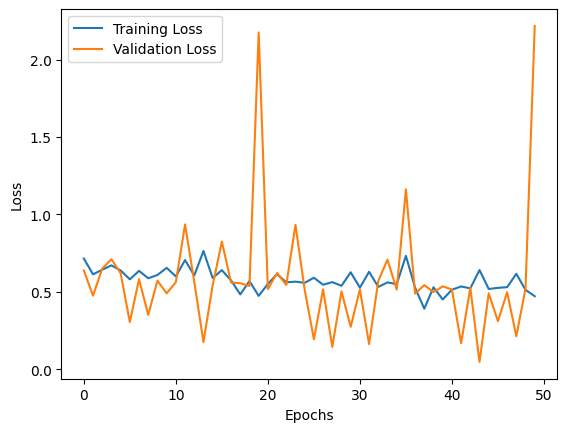

In [26]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Save the Model

In [28]:
# Save the model to the Kaggle working directory
model.save('/kaggle/working/solar_panel_classifier_1.h5')


In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalization for the model
    return img_array

# Load your pre-trained model
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/solar_panel_classifier_1.h5')

# Path to the downloaded image
img_path = '/kaggle/input/test-dataset/solar-panel-surface.png'

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)
predicted_class = 'Clean' if predictions[0] > 0.5 else 'Dusty'
print(f'The model predicts: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
The model predicts: Clean
